In [ ]:
# 1.3. 데이터 시각화 - 주요 차트 내용 중 박스 플롯 hue 구현 예제 코드

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Seaborn 내장 데이터셋 로드
tips = sns.load_dataset('tips')

# 데이터 준비
days = tips['day'].unique()
smokers = tips['smoker'].unique()

plt.figure(figsize=(8, 5))

# 각 day와 smoker 그룹별로 박스플롯 그리기
positions = []
data_to_plot = []
pos = 1

for day in sorted(days):  # day 순서대로
    for smoker in sorted(smokers):  # smoker = No, Yes
        group = tips[(tips['day'] == day) & (tips['smoker'] == smoker)]['total_bill']
        data_to_plot.append(group)
        positions.append(pos)
        pos += 1
    pos += 1  # day 사이 간격

# 박스플롯 그리기
bp = plt.boxplot(data_to_plot, positions=positions, widths=0.6, patch_artist=True)

# 색상 채우기 (smoker 구분)
colors = ['lightblue', 'lightcoral'] * len(days)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# x축 레이블: day 가운데 배치
xticks = []
xlabels = []
for i, day in enumerate(sorted(days)):
    xticks.append((i* (len(smokers)+1)) + 1.5)  # day 그룹의 중앙
    xlabels.append(day)

plt.xticks(xticks, xlabels)
plt.xlabel("day")
plt.ylabel("total_bill")
plt.title('Total Bill Distribution by Day and Smoker')

# 범례 추가
from matplotlib.patches import Patch
legend_handles = [Patch(color='lightblue', label='No'),
                  Patch(color='lightcoral', label='Yes')]
plt.legend(handles=legend_handles, title="smoker")

plt.show()

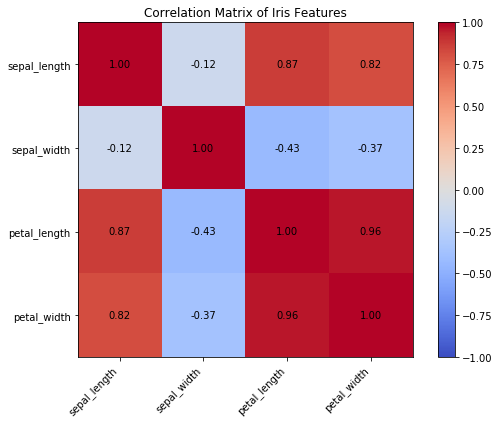

In [49]:
# 1.3. 데이터 시각화 - 주요 차트 내용 중 heatmap 예제 코드

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Seaborn 내장 데이터셋 로드
iris = sns.load_dataset('iris')

# 수치형 변수 간 상관계수 계산
corr = iris.corr()

# 히트맵 그리기
fig, ax = plt.subplots(figsize=(8, 6))

# imshow로 색상 맵 시각화
cax = ax.imshow(corr.values, cmap='coolwarm', vmin=-1, vmax=1)

# 컬럼 이름으로 x, y축 라벨 설정
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticklabels(corr.columns)

# 각 셀에 상관계수 값 표시
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        ax.text(j, i, f"{corr.values[i, j]:.2f}", ha='center', va='center', color='black')

# 컬러바 추가
fig.colorbar(cax)

plt.title('Correlation Matrix of Iris Features')
plt.tight_layout()
plt.show()


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
from statsmodels.stats.weightstats import ztest
import numpy as np

# 표본 데이터 생성 (실제로는 측정된 데이터 사용)
np.random.seed(0)
sample_iq = np.random.normal(loc=105, scale=15, size=30)

# 모집단 평균 (기준값)
pop_mean = 100

# 단일표본 Z-검정 수행
# value: 귀무가설에서의 평균 (μ₀)
# ddof=0: 모집단 표준편차를 사용한다는 의미 (기본값)
z_statistic, p_value = ztest(sample_iq, value=pop_mean)

print("--- One-sample Z-test ---")
print(f"Z-statistic: {z_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("귀무가설 기각: 프로그램은 IQ에 유의미한 영향을 미쳤습니다.")
else:
    print("귀무가설 기각 실패: 프로그램의 영향이 유의미하지 않습니다.")

--- One-sample Z-test ---
Z-statistic: 3.8637
P-value: 0.0001
귀무가설 기각: 프로그램은 IQ에 유의미한 영향을 미쳤습니다.


In [2]:
# 표본 데이터 생성
np.random.seed(1)
sample_a_height = np.random.normal(loc=175, scale=5, size=50)
sample_b_height = np.random.normal(loc=173, scale=6, size=60)

# 독립표본 Z-검정 수행
# value=0: 두 평균의 차이가 0이라는 귀무가설
z_statistic, p_value = ztest(sample_a_height, sample_b_height, value=0)

print("--- Two-sample Z-test ---")
print(f"Z-statistic: {z_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("귀무가설 기각: 두 도시의 평균 키는 유의미하게 다릅니다.")
else:
    print("귀무가설 기각 실패: 두 도시의 평균 키는 차이가 없습니다.")

--- Two-sample Z-test ---
Z-statistic: 1.2027
P-value: 0.2291
귀무가설 기각 실패: 두 도시의 평균 키는 차이가 없습니다.


In [3]:
from statsmodels.stats.proportion import proportions_ztest

# 데이터 설정
count = np.array([150, 240]) # 각 그룹에서 성공(인지)한 횟수
nobs = np.array([1000, 1200]) # 각 그룹의 전체 관측(표본) 수

# 두 집단 비율 Z-검정 수행
z_statistic, p_value = proportions_ztest(count, nobs, value=0)

print("--- Z-test for two proportions ---")
print(f"Z-statistic: {z_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("귀무가설 기각: 광고 캠페인 전후의 인지도는 유의미하게 다릅니다.")
else:
    print("귀무가설 기각 실패: 인지도 차이가 유의미하지 않습니다.")

--- Z-test for two proportions ---
Z-statistic: -3.0577
P-value: 0.0022
귀무가설 기각: 광고 캠페인 전후의 인지도는 유의미하게 다릅니다.


In [4]:
import numpy as np
from scipy.stats import f

# 표본 데이터 생성
np.random.seed(0)
line_a_weights = np.random.normal(loc=100, scale=5, size=20)
line_b_weights = np.random.normal(loc=100, scale=8, size=20)

# 1. 각 그룹의 분산 계산
var_a = np.var(line_a_weights, ddof=1)
var_b = np.var(line_b_weights, ddof=1)

# 2. F-통계량 계산 (큰 분산 / 작은 분산)
if var_a > var_b:
    f_statistic = var_a / var_b
    dfn = len(line_a_weights) - 1 # 분자의 자유도
    dfd = len(line_b_weights) - 1 # 분모의 자유도
else:
    f_statistic = var_b / var_a
    dfn = len(line_b_weights) - 1
    dfd = len(line_a_weights) - 1

# 3. p-value 계산 (양측 검정이므로 꼬리 확률에 2를 곱함)
# F.cdf는 왼쪽 꼬리 확률, F.sf는 오른쪽 꼬리 확률 (1 - cdf)
p_value = f.sf(f_statistic, dfn, dfd) * 2

print("--- F-test for Equality of Variances ---")
print(f"Variance of Line A: {var_a:.4f}")
print(f"Variance of Line B: {var_b:.4f}")
print(f"F-statistic: {f_statistic:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("귀무가설 기각: 두 집단의 분산은 유의미하게 다릅니다.")
else:
    print("귀무가설 기각 실패: 두 집단의 분산은 차이가 없습니다.")

--- F-test for Equality of Variances ---
Variance of Line A: 19.0213
Variance of Line B: 95.0513
F-statistic: 4.9971
p-value: 0.0010
귀무가설 기각: 두 집단의 분산은 유의미하게 다릅니다.


In [5]:
from scipy.stats import f_oneway

# 표본 데이터 생성
fertilizer_a = [20, 22, 19, 21, 23]
fertilizer_b = [25, 27, 26, 24, 28]
fertilizer_c = [18, 20, 19, 17, 16]

# 일원배치 분산분석(One-way ANOVA) 수행
f_statistic, p_value = f_oneway(fertilizer_a, fertilizer_b, fertilizer_c)

print("\n--- F-test in One-way ANOVA ---")
print(f"F-statistic: {f_statistic:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("귀무가설 기각: 적어도 한 비료의 효과는 다른 비료와 다릅니다.")
else:
    print("귀무가설 기각 실패: 비료 종류에 따른 평균 키 차이가 없습니다.")


--- F-test in One-way ANOVA ---
F-statistic: 32.6667
p-value: 0.0000
귀무가설 기각: 적어도 한 비료의 효과는 다른 비료와 다릅니다.


In [9]:
import pandas as pd
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 데이터 생성
method_a = [85, 88, 79, 92, 84]
method_b = [75, 78, 81, 72, 79]
method_c = [90, 94, 88, 91, 95]

# 1. ANOVA 검정 (scipy)
f_statistic, p_value = f_oneway(method_a, method_b, method_c)
print("--- One-way ANOVA (scipy) ---")
print(f"F-statistic: {f_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("귀무가설 기각: 교육 방법에 따른 평균 점수 차이가 유의미합니다.")
else:
    print("귀무가설 기각 실패: 평균 점수 차이가 유의미하지 않습니다.")

# 2. 사후 분석 (Tukey's HSD)
# 데이터를 long format으로 변환
df = pd.DataFrame({'score': method_a + method_b + method_c,
                    'group': ['A'] * 5 + ['B'] * 5 + ['C'] * 5})

tukey_result = pairwise_tukeyhsd(endog=df['score'], groups=df['group'], alpha=0.05)
print("\n--- Tukey's HSD Post-hoc Test ---")
print(tukey_result)

--- One-way ANOVA (scipy) ---
F-statistic: 18.3175
P-value: 0.0002
귀무가설 기각: 교육 방법에 따른 평균 점수 차이가 유의미합니다.

--- Tukey's HSD Post-hoc Test ---
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     A      B     -8.6 0.0104 -15.0692 -2.1308   True
     A      C      6.0 0.0701  -0.4692 12.4692  False
     B      C     14.6 0.0002   8.1308 21.0692   True
-----------------------------------------------------


In [19]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg

# 데이터 불러오기
df_two_way = pg.read_dataset('anova2')

# 1. 이원배치 분산분석 (statsmodels)
# C(Blend), C(Crop), 그리고 상호작용항 C(Blend):C(Crop)
model = ols('Yield ~ C(Blend) + C(Crop) + C(Blend):C(Crop)', data=df_two_way).fit()
anova_table_sm = sm.stats.anova_lm(model, typ=2)
print("--- Two-way ANOVA (statsmodels) ---")
print(anova_table_sm)
'''
--- Two-way ANOVA (statsmodels) ---
                       sum_sq    df         F    PR(>F)
C(Blend)             2.041667   1.0  0.003768  0.951730
C(Crop)           2736.583333   2.0  2.525235  0.107978
C(Blend):C(Crop)  2360.083333   2.0  2.177813  0.142223
Residual          9753.250000  18.0       NaN       NaN
'''

# 2. 이원배치 분산분석 (pingouin)
print("\n--- Two-way ANOVA (pingouin) ---")
anova_table_pg = pg.anova(data=df_two_way, dv='Yield', between=['Blend', 'Crop'], detailed=True)
print(anova_table_pg)
'''
--- Two-way ANOVA (pingouin) ---
         Source           SS  DF           MS         F     p-unc       np2
0         Blend     2.041667   1     2.041667  0.003768  0.951730  0.000209
1          Crop  2736.583333   2  1368.291667  2.525235  0.107978  0.219105
2  Blend * Crop  2360.083333   2  1180.041667  2.177813  0.142223  0.194834
3      Residual  9753.250000  18   541.847222       NaN       NaN       NaN
'''

--- Two-way ANOVA (statsmodels) ---
                       sum_sq    df         F    PR(>F)
C(Blend)             2.041667   1.0  0.003768  0.951730
C(Crop)           2736.583333   2.0  2.525235  0.107978
C(Blend):C(Crop)  2360.083333   2.0  2.177813  0.142223
Residual          9753.250000  18.0       NaN       NaN

--- Two-way ANOVA (pingouin) ---
         Source           SS  DF           MS         F     p-unc       np2
0         Blend     2.041667   1     2.041667  0.003768  0.951730  0.000209
1          Crop  2736.583333   2  1368.291667  2.525235  0.107978  0.219105
2  Blend * Crop  2360.083333   2  1180.041667  2.177813  0.142223  0.194834
3      Residual  9753.250000  18   541.847222       NaN       NaN       NaN


In [20]:
from scipy.stats import wilcoxon, shapiro

sample_weights = [48, 51, 52, 47, 55, 46, 53, 49, 54, 45]
pop_median = 50

# 정규성 검정 (표본이 작아 정규성을 가정하기 어려움)
print(f"Shapiro p-value: {shapiro(sample_weights).pvalue:.4f}")

# 단일표본 Wilcoxon 검정 수행
# 검정은 (x - pop_median)에 대해 수행됨
statistic, p_value = wilcoxon([w - pop_median for w in sample_weights])
# 또는 scipy 1.7.0+ 에서는 다음과 같이 직접 수행 가능
# statistic, p_value = wilcoxon(sample_weights, y=None, alternative='two-sided') # 단, 이 경우 중앙값이 0인지 검정

print("\n--- One-sample Wilcoxon Signed-rank Test ---")
print(f"Statistic: {statistic:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("귀무가설 기각: 쿠키 무게의 중앙값은 50g과 유의미하게 다릅니다.")
else:
    print("귀무가설 기각 실패: 쿠키 무게의 중앙값은 50g과 다르다고 할 수 없습니다.")

Shapiro p-value: 0.6769

--- One-sample Wilcoxon Signed-rank Test ---
Statistic: 27.5000
P-value: 1.0000
귀무가설 기각 실패: 쿠키 무게의 중앙값은 50g과 다르다고 할 수 없습니다.


In [21]:
stress_before = [8, 7, 9, 6, 8, 7, 9, 5, 8, 7]
stress_after = [6, 5, 7, 5, 6, 6, 8, 4, 7, 5]

# 차이값의 정규성 검정
differences = [b - a for b, a in zip(stress_before, stress_after)]
print(f"Shapiro p-value on differences: {shapiro(differences).pvalue:.4f}") # 정규성 불만족 가정

# 대응표본 Wilcoxon 검정 수행
# 대립가설: before > after (차이가 양수), 즉 프로그램이 효과가 있다.
# wilcoxon(x, y)는 (x-y)의 중앙값이 0인지 검정. 
# H1: before > after  =>  before - after > 0 이므로 alternative='greater'
statistic, p_value = wilcoxon(stress_before, stress_after, alternative='greater')

print("\n--- Paired-samples Wilcoxon Signed-rank Test ---")
print(f"Statistic: {statistic:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("귀무가설 기각: 프로그램은 스트레스 지수를 유의미하게 낮췄습니다.")
else:
    print("귀무가설 기각 실패: 프로그램의 효과가 유의미하지 않습니다.")

Shapiro p-value on differences: 0.0003

--- Paired-samples Wilcoxon Signed-rank Test ---
Statistic: 55.0000
P-value: 0.0010
귀무가설 기각: 프로그램은 스트레스 지수를 유의미하게 낮췄습니다.


In [29]:
from scipy.stats import mannwhitneyu, shapiro

# 표본 데이터 생성
# A 교수법은 점수가 약간 높고, B 교수법은 분산이 더 큰 비정규 데이터
np.random.seed(1)
teaching_method_A = [85, 88, 79, 92, 84, 95, 80, 91, 87, 83]
teaching_method_B = np.random.chisquare(df=10, size=12) * 5 + 30 # 비정규 데이터

# 정규성 검정
print(f"Method A Shapiro p-value: {shapiro(teaching_method_A).pvalue:.4f}") # 0.9091
print(f"Method B Shapiro p-value: {shapiro(teaching_method_B).pvalue:.4f}") # 0.0241, 정규성 불만족

# 맨-휘트니 U 검정 수행
# H1: 두 그룹의 분포가 다르다 (양측 검정)
statistic, p_value = mannwhitneyu(teaching_method_A, teaching_method_B, alternative='two-sided')

print("\n--- Mann-Whitney U Test ---")
print(f"U-statistic: {statistic:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("귀무가설 기각: 두 교수법에 따른 점수 분포는 유의미하게 다릅니다.")
else:
    print("귀무가설 기각 실패: 두 교수법에 따른 점수 분포는 차이가 없습니다.")
'''
--- Mann-Whitney U Test ---
U-statistic: 80.0000
P-value: 0.1985
귀무가설 기각 실패: 두 교수법에 따른 점수 분포는 차이가 없습니다.
'''

# 단측 검정 예시
# H1: A 교수법의 점수가 B 교수법보다 높다 (A > B)
stat_greater, p_greater = mannwhitneyu(teaching_method_A, teaching_method_B, alternative='greater')
print("\n--- One-sided Test (A > B) ---")
print(f"P-value: {p_greater:.4f}")
'''
--- One-sided Test (A > B) ---
P-value: 0.0993
'''

Method A Shapiro p-value: 0.9091
Method B Shapiro p-value: 0.0241

--- Mann-Whitney U Test ---
U-statistic: 80.0000
P-value: 0.1985
귀무가설 기각 실패: 두 교수법에 따른 점수 분포는 차이가 없습니다.

--- One-sided Test (A > B) ---
P-value: 0.0993


'\n--- One-sided Test (A > B) ---\nP-value: 0.0993\n'

In [23]:
from scipy.stats import wilcoxon, shapiro

sample_weights = [48, 51, 52, 47, 55, 46, 53, 49, 54, 45]
pop_median = 50

# 정규성 검정 (표본이 작아 정규성을 가정하기 어려움)
print(f"Shapiro p-value: {shapiro(sample_weights).pvalue:.4f}") # 0.6769

# 단일표본 Wilcoxon 검정 수행
# 검정은 (x - pop_median)에 대해 수행됨
statistic, p_value = wilcoxon([w - pop_median for w in sample_weights])
# 또는 scipy 1.7.0+ 에서는 다음과 같이 직접 수행 가능
statistic, p_value = wilcoxon(sample_weights, y=None, alternative='two-sided') # 단, 이 경우 중앙값이 0인지 검정

print("\n--- One-sample Wilcoxon Signed-rank Test ---")
print(f"Statistic: {statistic:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("귀무가설 기각: 쿠키 무게의 중앙값은 50g과 유의미하게 다릅니다.")
else:
    print("귀무가설 기각 실패: 쿠키 무게의 중앙값은 50g과 다르다고 할 수 없습니다.")

Shapiro p-value: 0.6769

--- One-sample Wilcoxon Signed-rank Test ---
Statistic: 0.0000
P-value: 0.0020
귀무가설 기각: 쿠키 무게의 중앙값은 50g과 유의미하게 다릅니다.


In [30]:
import numpy as np
from scipy.stats import kruskal

# 데이터 생성 (세 개의 독립적인 그룹)
# 각 그룹이 정규분포를 따르지 않는다고 가정
group1 = [7, 8, 8, 9, 10, 11, 12]
group2 = [9, 9, 10, 11, 12, 13, 14]
group3 = [12, 13, 14, 14, 15, 16, 17]

# 크루스칼-왈리스 H 검정 수행
statistic, p_value = kruskal(group1, group2, group3)

print(f"Kruskal-Wallis H statistic: {statistic:.4f}")
print(f"P-value: {p_value:.4f}")

# 결과 해석
alpha = 0.05
if p_value < alpha:
    print("귀무가설 기각: 적어도 한 집단의 중앙값은 다른 집단과 통계적으로 유의미한 차이가 있습니다.")
else:
    print("귀무가설 채택: 집단 간 중앙값의 차이가 통계적으로 유의미하지 않습니다.")

# 만약 귀무가설이 기각되었다면, 사후 분석(Post-hoc test)을 통해 어느 집단 간에 차이가 있는지 확인해야 합니다.
# 비모수 검정의 사후 분석으로는 Dunn's test, Conover's test 등이 사용될 수 있습니다.
# statsmodels 라이브러리나 scikit-posthocs 패키지를 활용할 수 있습니다.

# scikit-posthocs를 사용한 Dunn's test 예시
# !pip install scikit-posthocs
import scikit_posthocs as sp
import pandas as pd

data = pd.DataFrame({
    'value': group1 + group2 + group3,
    'group': ['group1'] * len(group1) + ['group2'] * len(group2) + ['group3'] * len(group3)
})

# Dunn's test 수행 (p-value 조정 방법: Bonferroni)
posthoc_df = sp.posthoc_dunn(data, val_col='value', group_col='group', p_adjust='bonferroni')

print("Dunn's Post-hoc test (Bonferroni correction):")
print(posthoc_df)

Kruskal-Wallis H statistic: 12.3866
P-value: 0.0020
귀무가설 기각: 적어도 한 집단의 중앙값은 다른 집단과 통계적으로 유의미한 차이가 있습니다.
Dunn's Post-hoc test (Bonferroni correction):
          group1    group2    group3
group1  1.000000  0.559898  0.001473
group2  0.559898  1.000000  0.091180
group3  0.001473  0.091180  1.000000


In [31]:
import numpy as np
from scipy.stats import chisquare

# 예시: 한 해 동안 특정 상점에서 요일별 방문자 수가 균일한지 검정
# 귀무가설: 요일별 방문자 수는 차이가 없다 (모두 동일하다).
# 대립가설: 요일별 방문자 수는 차이가 있다.

# 관찰 빈도 (월, 화, 수, 목, 금, 토, 일)
observed_freq = np.array([100, 120, 110, 105, 140, 155, 150])

# 기대 빈도: 총 방문자 수를 요일 수(7)로 나눈 값
total_visitors = np.sum(observed_freq)
expected_freq = np.full_like(observed_freq, total_visitors / 7)

# 카이제곱 적합도 검정 수행
# f_exp를 명시하지 않으면 자동으로 균일 분포를 가정하여 계산합니다.
statistic, p_value = chisquare(f_obs=observed_freq)

print(f"Chi-squared statistic: {statistic:.4f}")
print(f"P-value: {p_value:.4f}")

# 결과 해석
alpha = 0.05
if p_value < alpha:
    print("귀무가설 기각: 요일별 방문자 수에는 통계적으로 유의미한 차이가 있습니다.")
else:
    print("귀무가설 채택: 요일별 방문자 수는 균일하다고 볼 수 있습니다.")

Chi-squared statistic: 24.0341
P-value: 0.0005
귀무가설 기각: 요일별 방문자 수에는 통계적으로 유의미한 차이가 있습니다.


In [32]:
import pandas as pd
from scipy.stats import chi2_contingency

# 예시: 교육 수준과 소득 수준 간의 연관성(독립성) 검정
# 귀무가설: 교육 수준과 소득 수준은 서로 독립이다.
# 대립가설: 교육 수준과 소득 수준은 서로 연관되어 있다.

# 데이터 (분할표)
data = {
    '고졸': [50, 70, 30],
    '대졸': [80, 120, 50],
    '대학원졸': [40, 90, 70]
}
index = ['소득 하', '소득 중', '소득 상']
observed_table = pd.DataFrame(data, index=index)

print("관찰 빈도 분할표:")
print(observed_table)

# 카이제곱 독립성 검정 수행
chi2, p_value, dof, expected = chi2_contingency(observed_table)

print(f"Chi-squared statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Degrees of Freedom: {dof}")
print("기대 빈도 분할표:")
print(pd.DataFrame(expected, index=index, columns=data.keys()))

# 결과 해석
alpha = 0.05
if p_value < alpha:
    print("귀무가설 기각: 교육 수준과 소득 수준은 통계적으로 유의미한 연관이 있습니다.")
else:
    print("귀무가설 채택: 교육 수준과 소득 수준은 서로 독립이라고 볼 수 있습니다.")

관찰 빈도 분할표:
      고졸   대졸  대학원졸
소득 하  50   80    40
소득 중  70  120    90
소득 상  30   50    70
Chi-squared statistic: 19.6261
P-value: 0.0006
Degrees of Freedom: 4
기대 빈도 분할표:
        고졸          대졸       대학원졸
소득 하  42.5   70.833333  56.666667
소득 중  70.0  116.666667  93.333333
소득 상  37.5   62.500000  50.000000
귀무가설 기각: 교육 수준과 소득 수준은 통계적으로 유의미한 연관이 있습니다.


In [33]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

# 예시: 한 공장에서 생산된 제품 1000개 중 45개가 불량품으로 나왔다.
# 이 공장의 불량률이 3%라고 할 수 있는가? (유의수준 5%)

# 귀무가설: 공장의 불량률은 3%이다. (p = 0.03)
# 대립가설: 공장의 불량률은 3%가 아니다. (p ≠ 0.03)

count = 45  # 불량품 수 (성공 횟수)
nobs = 1000 # 총 생산량 (표본 크기)
value = 0.03 # 귀무가설의 비율

# 단일 표본 비율 검정 수행
stat, p_value = proportions_ztest(count, nobs, value, alternative='two-sided')

print(f"Z-statistic: {stat:.4f}")
print(f"P-value: {p_value:.4f}")

# 결과 해석
alpha = 0.05
if p_value < alpha:
    print("귀무가설 기각: 공장의 불량률은 3%와 통계적으로 유의미한 차이가 있습니다.")
else:
    print("귀무가설 채택: 공장의 불량률이 3%라는 주장을 기각할 수 없습니다.")

# 만약 표본 크기가 작다면 (e.g., n*p < 10), 이항 검정을 사용
from scipy.stats import binom_test

# 예시: 20개의 제품 중 3개가 불량 (n*p0 = 20*0.03 = 0.6 < 10)
p_val_binom = binom_test(x=3, n=20, p=0.03, alternative='two-sided')
print(f"\nBinomial test P-value (for small sample): {p_val_binom:.4f}")

Z-statistic: 2.2881
P-value: 0.0221
귀무가설 기각: 공장의 불량률은 3%와 통계적으로 유의미한 차이가 있습니다.

Binomial test P-value (for small sample): 0.0210


In [34]:
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

# 예시: 두 가지 다른 웹사이트 디자인(A, B)의 구매 전환율 비교
# 귀무가설: 두 디자인의 구매 전환율은 동일하다. (p_A = p_B)
# 대립가설: 두 디자인의 구매 전환율은 다르다. (p_A ≠ p_B)

# A 디자인: 1500명 방문, 100명 구매
# B 디자인: 1600명 방문, 130명 구매

count = np.array([100, 130])   # 각 그룹의 성공 횟수
nobs = np.array([1500, 1600]) # 각 그룹의 표본 크기

# 두 표본 비율 검정 수행 (value=None 으로 설정)
stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')

print(f"Z-statistic: {stat:.4f}")
print(f"P-value: {p_value:.4f}")

# 결과 해석
alpha = 0.05
if p_value < alpha:
    print("귀무가설 기각: 두 웹사이트 디자인의 구매 전환율에는 통계적으로 유의미한 차이가 있습니다.")
else:
    print("귀무가설 채택: 두 웹사이트 디자인의 구매 전환율 차이는 유의미하지 않습니다.")

# 참고: 두 표본 비율 검정은 2x2 분할표에 대한 카이제곱 독립성 검정과 통계적으로 동일한 결과를 제공합니다.
# Z^2 = chi^2
from scipy.stats import chi2_contingency

# [성공, 실패] 형태로 분할표 생성
# 성공: 구매, 실패: 비구매
observed = np.array([
    [100, 1500 - 100], # A 디자인
    [130, 1600 - 130]  # B 디자인
])

chi2, p_val_chi2, _, _ = chi2_contingency(observed, correction=False) # correction=False로 설정해야 Z^2=chi^2 관계 성립

print(f"\nChi-squared statistic: {chi2:.4f}")
print(f"P-value from Chi-squared test: {p_val_chi2:.4f}")
print(f"Z-statistic squared: {stat**2:.4f}") # Z^2 값과 chi2 값이 동일함을 확인

Z-statistic: -1.5482
P-value: 0.1216
귀무가설 채택: 두 웹사이트 디자인의 구매 전환율 차이는 유의미하지 않습니다.

Chi-squared statistic: 2.3970
P-value from Chi-squared test: 0.1216
Z-statistic squared: 2.3970


In [35]:
import numpy as np
from statsmodels.stats.contingency_tables import mcnemar

# 예시: 새로운 약물 치료법의 효과 검증
# 100명의 환자를 대상으로 약물 투여 전과 후의 질병 유무를 조사

# 분할표 데이터
#           | 후: 완치 | 후: 비완치 | 
# -------------------------------------
# 전: 비완치 |    60    |     10     |  (c)
# 전: 완치   |    20    |     10     |  (b)

# statsmodels의 mcnemar 함수는 다음과 같은 형식의 테이블을 기대합니다:
# [[a, b], [c, d]]
# a: 그룹1=Yes, 그룹2=Yes
# b: 그룹1=Yes, 그룹2=No
# c: 그룹1=No, 그룹2=Yes
# d: 그룹1=No, 그룹2=No

# 위의 예시를 함수에 맞는 형태로 재구성:
# 그룹1: 치료 전 (Yes=완치, No=비완치)
# 그룹2: 치료 후 (Yes=완치, No=비완치)

# a (전:완치, 후:완치) = 20
# b (전:완치, 후:비완치) = 10
# c (전:비완치, 후:완치) = 60
# d (전:비완치, 후:비완치) = 10

table = np.array([[20, 10],
                  [60, 10]])

# 맥니마 검정 수행
# b+c = 10+60 = 70 이므로 충분히 크지만, exact=True 사용이 일반적으로 더 안전합니다.
result = mcnemar(table, exact=True)

print(f"Statistic (b+c): {result.statistic}") # exact=True일 경우, b와 c 중 작은 값
print(f"P-value: {result.pvalue:.4f}")

# 결과 해석
alpha = 0.05
if result.pvalue < alpha:
    print("귀무가설 기각: 약물 투여 전후의 완치율에는 통계적으로 유의미한 변화가 있습니다.")
else:
    print("귀무가설 채택: 약물 투여 전후의 완치율 변화는 유의미하지 않습니다.")


# 만약 exact=False (카이제곱 근사)를 사용한다면
result_chi2 = mcnemar(table, exact=False, correction=True)
print("\n--- Chi-squared approximation ---")
print(f"Chi-squared statistic: {result_chi2.statistic:.4f}")
print(f"P-value: {result_chi2.pvalue:.4f}")

Statistic (b+c): 10.0
P-value: 0.0000
귀무가설 기각: 약물 투여 전후의 완치율에는 통계적으로 유의미한 변화가 있습니다.

--- Chi-squared approximation ---
Chi-squared statistic: 34.3000
P-value: 0.0000


In [36]:
import numpy as np
from statsmodels.stats.contingency_tables import cochrans_q

# 예시: 10명의 학생이 세 번의 시험(Test1, Test2, Test3)에서 합격(1) 또는 불합격(0)한 결과
# 귀무가설: 세 시험의 합격률은 모두 동일하다.
# 대립가설: 적어도 한 시험의 합격률은 다른 시험과 다르다.

data = np.array([
#   T1, T2, T3
    [1, 1, 0],  # 학생 1
    [1, 1, 1],  # 학생 2
    [0, 1, 1],  # 학생 3
    [0, 0, 0],  # 학생 4
    [1, 1, 0],  # 학생 5
    [0, 1, 0],  # 학생 6
    [1, 0, 0],  # 학생 7
    [1, 1, 1],  # 학생 8
    [0, 1, 0],  # 학생 9
    [0, 1, 1]   # 학생 10
])

# 코크란의 Q 검정 수행
result = cochrans_q(data)

print(f"Cochran's Q statistic: {result.statistic:.4f}")
print(f"P-value: {result.pvalue:.4f}")

# 결과 해석
alpha = 0.05
if result.pvalue < alpha:
    print("귀무가설 기각: 세 시험의 합격률에는 통계적으로 유의미한 차이가 있습니다.")
else:
    print("귀무가설 채택: 세 시험의 합격률은 통계적으로 차이가 없다고 볼 수 있습니다.")

# 사후 분석 (Post-hoc Test)
# 만약 귀무가설이 기각되었다면, 어느 쌍(예: Test1-Test2, Test1-Test3, Test2-Test3)에서
# 차이가 나는지 확인하기 위해 사후 분석을 수행해야 합니다.
# 일반적으로 각 쌍에 대해 맥니마 검정(McNemar's Test)을 수행하고,
# 다중 비교에 따른 1종 오류 증가를 보정하기 위해 본페로니 교정(Bonferroni correction) 등을 적용합니다.

# !pip install scikit-posthocs
import scikit_posthocs as sp
import pandas as pd

# 데이터를 long format으로 변경
df = pd.DataFrame(data, columns=['Test1', 'Test2', 'Test3'])
df['id'] = range(len(df))
df_long = pd.melt(df, id_vars='id', var_name='test', value_name='result')

# 사후 분석 수행 (맥니마 검정 기반)
posthoc_df = sp.posthoc_mcnemar(df_long, val_col='result', group_col='test', block_col='id', p_adjust='bonferroni')

print("\nPost-hoc test (McNemar with Bonferroni correction):")
print(posthoc_df)

Cochran's Q statistic: 3.7143
P-value: 0.1561
귀무가설 채택: 세 시험의 합격률은 통계적으로 차이가 없다고 볼 수 있습니다.


AttributeError: module 'scikit_posthocs' has no attribute 'posthoc_mcnemar'

In [39]:
import itertools

test_names = ['Test1', 'Test2', 'Test3']

# 사후 분석: 모든 쌍에 대해 McNemar 수행
results = []
for i, j in itertools.combinations(range(data.shape[1]), 2):
    # 2x2 교차표 생성
    table = pd.crosstab(data[:, i], data[:, j])
    # McNemar 검정 수행 (exact=False는 chi-square 근사)
    result = mcnemar(table, exact=False, correction=True)
    results.append({
        'comparison': f'{test_names[i]} vs {test_names[j]}',
        'statistic': result.statistic,
        'p_uncorrected': result.pvalue
    })

# Bonferroni 보정
p_values = [r['p_uncorrected'] for r in results]
p_adjusted = np.minimum(np.array(p_values) * len(p_values), 1.0)
for idx, r in enumerate(results):
    r['p_adjusted'] = p_adjusted[idx]
    r['reject'] = p_adjusted[idx] < alpha

# 결과 출력
posthoc_df = pd.DataFrame(results)
print("\nPost-hoc test (McNemar with Bonferroni correction):")
print(posthoc_df)


Post-hoc test (McNemar with Bonferroni correction):
       comparison  statistic  p_uncorrected  p_adjusted  reject
0  Test1 vs Test2       0.80       0.371093    1.000000   False
1  Test1 vs Test3       0.00       1.000000    1.000000   False
2  Test2 vs Test3       2.25       0.133614    0.400843   False
